<a href="https://colab.research.google.com/github/VardhanVelamakanni/Mental_stres_Prediction_BandDecomposition_CWT/blob/main/Pipeline2(EEG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Raw data mat.zip to Raw data mat.zip
Saving Documents and Code.zip to Documents and Code.zip
Saving DASPS+HAM labels.zip to DASPS+HAM labels.zip


In [2]:
import os

BASE_DIR = "/content/DASPS"
os.makedirs(BASE_DIR, exist_ok=True)
print("Base directory created")


Base directory created


In [3]:
import shutil

for f in uploaded.keys():
    shutil.move(f, BASE_DIR + "/" + f)

os.listdir(BASE_DIR)


['DASPS+HAM labels.zip', 'Raw data mat.zip', 'Documents and Code.zip']

In [4]:
import zipfile

def unzip(zip_path, out):
    with zipfile.ZipFile(zip_path,'r') as z:
        z.extractall(out)

unzip("/content/DASPS/Raw data mat.zip", BASE_DIR)
unzip("/content/DASPS/DASPS+HAM labels.zip", BASE_DIR)

print("Extraction complete")


Extraction complete


In [5]:
!pip install h5py pywavelets scipy matplotlib numpy scikit-learn


In [6]:
import h5py, numpy as np

f = h5py.File("/content/DASPS/Raw data mat/S01.mat",'r')
key = list(f.keys())[0]
eeg = np.array(f[key])

print("EEG shape:", eeg.shape)


EEG shape: (12, 1920, 14)


In [7]:
import pywt
import numpy as np

def wavelet_denoise(signal, wavelet="db4", level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(signal)))

    denoised = [pywt.threshold(c, uthresh, mode="soft") for c in coeffs]
    return pywt.waverec(denoised, wavelet)


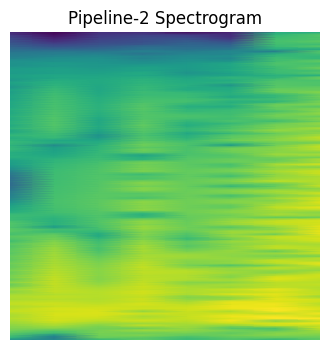

In [9]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

FS = 128
signal = eeg[0, :, 0] # Select first channel of the first trial
clean = wavelet_denoise(signal)

f, t, Sxx = spectrogram(clean, FS)

plt.figure(figsize=(4,4))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud') # Added shading='gouraud'
plt.title("Pipeline-2 Spectrogram")
plt.axis("off")
plt.show()

In [10]:
os.makedirs("/content/images/stress", exist_ok=True)
os.makedirs("/content/images/no_stress", exist_ok=True)


In [16]:
def save_spectrogram(signal, path):
    f, t, Sxx = spectrogram(signal, FS)
    plt.figure(figsize=(3,3))
    # Add a small epsilon to avoid log10(0) which causes RuntimeWarning
    plt.pcolormesh(t, f, 10*np.log10(Sxx + 1e-10), shading='gouraud')
    plt.axis("off")
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [17]:
for ch in range(eeg.shape[0]): # Iterate over channels
    for trial_idx in range(eeg.shape[2]): # Iterate over trials
        # Select a 1D signal for a specific channel and trial
        signal_1d = eeg[ch, :, trial_idx]
        clean_1d = wavelet_denoise(signal_1d)
        # Save spectrogram with a unique filename including channel and trial index
        save_spectrogram(clean_1d, f"/content/images/stress/S01_CH{ch}_T{trial_idx}.png")

In [20]:
DATA_PATH = "/content/DASPS/Raw data mat"

for file in os.listdir(DATA_PATH):
    sid = file.replace(".mat","")
    f = h5py.File(DATA_PATH + "/" + file,'r')
    key = list(f.keys())[0]
    eeg = np.array(f[key])

    # Iterate over channels and trials to get a 1D signal
    for ch in range(eeg.shape[0]):
        for trial_idx in range(eeg.shape[2]):
            signal_1d = eeg[ch, :, trial_idx]
            clean_1d = wavelet_denoise(signal_1d)
            save_spectrogram(clean_1d,
                f"/content/images/stress/{sid}_CH{ch}_T{trial_idx}.png")

Converted all subjects to images

In [21]:
f = h5py.File("/content/DASPS/DASPS+HAM labels/DASPS+HAM labels.mat",'r')
labels = np.array(f[list(f.keys())[0]]).squeeze()


In [22]:
def get_binary_label(label):
    label = label.decode() if isinstance(label, bytes) else str(label)
    return 1 if label[0]=='1' else 0


In [23]:
BASE="/content/dataset"

folders=[
"train/stress","train/no_stress",
"val/stress","val/no_stress",
"test/stress","test/no_stress"
]

for f in folders:
    os.makedirs(os.path.join(BASE,f),exist_ok=True)


In [24]:
import glob, shutil

images = glob.glob("/content/images/stress/*.png")

for img in images:
    name=os.path.basename(img)
    sub=name.split("_")[0]
    idx=int(sub.replace("S",""))-1

    lab=get_binary_label(labels[idx])

    if lab==1:
        shutil.copy(img,f"{BASE}/train/stress/{name}")
    else:
        shutil.copy(img,f"{BASE}/train/no_stress/{name}")


In [25]:
from sklearn.model_selection import train_test_split

def split_class(cls):
    p=f"{BASE}/train/{cls}"
    files=os.listdir(p)
    train,temp=train_test_split(files,test_size=0.3,random_state=42)
    val,test=train_test_split(temp,test_size=0.5,random_state=42)

    for f in val:
        shutil.move(p+"/"+f,f"{BASE}/val/{cls}/"+f)
    for f in test:
        shutil.move(p+"/"+f,f"{BASE}/test/{cls}/"+f)

split_class("stress")
split_class("no_stress")


In [27]:
import shutil

shutil.make_archive(
    "/content/Pipeline2_dataset",
    "zip",
    "/content/dataset"
)

print("Pipeline-2 dataset zipped")


Pipeline-2 dataset zipped


In [28]:
from google.colab import files
files.download("/content/Pipeline2_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>